<h1>
<center>CFRM 521, Spring 2020</center>
</h1>

<h1>
<center>Franklin Williams</center>
</h1>

<h1>
<center> Comparison of Clustering Techniques for Portfolio Optimization</center>
</h1>


### Abstract

Mean-Variance optimization is known to have several drawbacks. One important drawback is the estimation error within the covariance matrix. Correlations between assets can be shown to be unstable and vary throughout time. Another issue with the standard covariance matrix used in practice is that it is has a high condition number. Lopez de Prado explains how this affects the standard Markowitz Mean-Variance optimization problem,

“…Markowitz’s solution is guaranteed to be numerically stable only if ρ ≈ 0, which is precisely the case when we don’t need it! The reason we needed Markowitz was to handle the ρ≉0 case, but the more we need Markowitz, the more numerically unstable is the estimation of ω_. This is Markowitz’s curse.” [1]
de Prado shows two clustering techniques utilized to generate portfolio allocations that outperform the standard Mean-Variance optimization within the context of Monte Carlo simulation: hierarchical clustering asset allocation (HCAA) [1] and hierarchical risk parity (HRP) [2]. 

For this project, the empirical performance and portfolio composition of these two portfolio-optimization-specific algorithms, standard mean-variance optimization, critical line method, and a benchmark (equal weight) are analyzed. Due to the issues listed above, we hypothesize that the HCAA and HRP algorithms will produce more consistent portfolio results in out-of-sample return data.

All portfolios will be constructed with a one-year look back period and rebalanced weekly.

Sources

[1] López de Prado, M. (2020): “Machine Learning for Asset Managers” 
https://www.cambridge.org/core/books/machine-learning-for-asset-managers/6D9211305EA2E425D33A9F38D0AE3545#fndtn-information

[2] López de Prado, M. (2016): “Building Diversified Portfolios that Outperform Out-of Sample.” Journal of Portfolio Management, Vol. 42, No. 4, pp. 59–69.  https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2708678

In [1]:
import pandas as pd
import numpy as np
import quandl
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform
from mlfinlab.portfolio_optimization.hrp import HierarchicalRiskParity
from mlfinlab.portfolio_optimization.cla import CLA
from mlfinlab.portfolio_optimization import MeanVarianceOptimisation
from mlfinlab.portfolio_optimization.hcaa import HierarchicalClusteringAssetAllocation
import seaborn as sns

np.random.seed(42)

/Users/Streater/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/Streater/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


### Data

Data used in this experiment were from Quandl: https://www.quandl.com/databases/SEP/data
The dataset titled Sharadar Equity Prices contains 10 years of daily OHLC information for 16,000+ US public companies. The data is adjusted for stock-splits and dividends. Additionally, both listed and delisted companies are included within the dataset. To generate a clean dataset, only companies with full price history were used. This creates survivorship bias within the results. Daily returns were converted to weekly returns. Additionally, in the interest of feasibility, computational costs, and time a small subset of stocks were chosen.

In [2]:
stock_prices = pd.read_csv("SHARADAR_SEP_b449cf91394bfd946c3c32e72ee7efb6.csv", )
stock_prices['date'] = pd.to_datetime(stock_prices['date'])
stock_prices.head()

,ticker,date,open,high,low,close,volume,dividends,closeunadj,lastupdated
0,A,2019-11-29,80.960,81.240,80.470,80.770,835780.0,0.0,80.770,2019-11-29
1,AA,2019-11-29,20.430,20.470,20.158,20.350,1223254.0,0.0,20.350,2019-11-29
2,AACG,2019-11-29,1.813,1.813,1.805,1.805,963.0,0.0,1.805,2019-11-29
3,AAGIY,2019-11-29,40.580,40.580,40.010,40.020,163700.0,0.0,40.020,2019-11-30
4,AAL,2019-11-29,28.920,29.265,28.660,28.740,2970843.0,0.0,28.740,2019-11-29


In [3]:
stock_prices = stock_prices.pivot(index='date', columns='ticker', values='close').dropna(axis=1)
stock_prices = stock_prices.sample(100, axis=1)

In [4]:
stock_prices.head()

ticker,UVE,ELY,HR,GIS,VIVO,RIG,LMNX,GLDD,SQM,NEON,...,RBA,UAMY,SRGZ,LUNMF,AME,XEC,BEBE,MTRX,BBD,LUNA
date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,6.07,7.84,21.52,35.45,21.65,86.78,14.83,6.58,38.61,5.0,...,22.76,0.45,21.6,4.33,17.156,55.17,63.6,10.94,13.981,2.20
2010-01-05,6.25,7.79,21.54,35.12,21.43,88.56,14.93,6.52,39.05,7.5,...,22.86,0.45,21.6,4.47,17.080,55.07,64.0,10.88,13.687,2.36
2010-01-06,6.25,8.03,21.20,35.33,21.55,91.66,15.16,6.79,40.01,7.5,...,22.66,0.45,21.6,4.59,17.098,54.99,65.4,11.20,13.655,2.65
2010-01-07,6.28,8.14,21.37,35.65,21.50,91.01,15.16,6.92,42.18,10.0,...,22.69,0.45,21.6,4.68,17.142,54.12,60.2,11.25,13.480,2.62
2010-01-08,6.40,8.04,21.21,35.36,21.71,93.00,15.22,6.99,43.25,7.5,...,22.82,0.45,25.2,4.72,17.476,55.13,61.7,11.49,13.618,4.50


In [5]:
stock_prices_downsampled = stock_prices.resample('W').last()
stock_prices_downsampled.head()

ticker,UVE,ELY,HR,GIS,VIVO,RIG,LMNX,GLDD,SQM,NEON,...,RBA,UAMY,SRGZ,LUNMF,AME,XEC,BEBE,MTRX,BBD,LUNA
date,,,,,,,,,,,,,,,,,,,,,
2010-01-10,6.40,8.04,21.21,35.360,21.71,93.00,15.22,6.99,43.25,7.5,...,22.82,0.45,25.20,4.72,17.476,55.13,61.7,11.49,13.618,4.50
2010-01-17,6.12,8.39,21.62,35.665,21.93,91.85,15.47,6.72,42.13,7.5,...,22.65,0.40,21.60,4.82,17.084,54.73,64.2,10.99,12.929,3.70
2010-01-24,5.99,8.25,21.12,35.480,21.21,85.72,14.73,6.06,39.64,7.5,...,21.20,0.39,25.56,4.35,16.609,52.97,61.0,10.55,10.882,3.37
2010-01-31,5.91,7.46,20.97,35.655,20.04,84.74,13.53,5.91,36.38,7.5,...,21.02,0.40,22.32,3.93,16.196,49.21,61.8,10.09,10.368,2.83
2010-02-07,5.65,7.48,20.87,34.315,20.05,83.99,14.24,5.50,35.89,7.5,...,20.37,0.45,23.04,3.94,16.129,50.56,71.1,9.49,10.199,2.98


In [6]:
stock_returns = stock_prices_downsampled.pct_change().dropna()

stock_returns_train_full, stock_returns_test = stock_returns.loc["2010":"2018"], stock_returns.loc["2019":]
stock_returns_train, stock_returns_validate = stock_returns_train_full[:"2017"], stock_returns_train_full["2018"]

In [7]:
expected_returns = stock_returns_train.mean()
expected_returns

ticker
UVE     0.005210
ELY     0.002230
HR      0.001434
GIS     0.001446
VIVO   -0.000238
          ...   
XEC     0.003146
BEBE   -0.002125
MTRX    0.002984
BBD     0.000418
LUNA    0.001078
Length: 100, dtype: float64

In [8]:
covariance_matrix = stock_returns_train.cov()
covariance_matrix

ticker,UVE,ELY,HR,GIS,VIVO,RIG,LMNX,GLDD,SQM,NEON,...,RBA,UAMY,SRGZ,LUNMF,AME,XEC,BEBE,MTRX,BBD,LUNA
ticker,,,,,,,,,,,,,,,,,,,,,
UVE,0.003357,0.000311,0.000229,0.000218,0.000454,0.000669,0.000520,0.000841,0.000498,0.000333,...,0.000342,0.000175,-0.000674,0.000789,0.000455,0.000449,0.001237,0.000509,0.000310,0.000262
ELY,0.000311,0.001814,0.000323,0.000100,0.000417,0.000453,0.000511,0.000645,0.000480,0.000248,...,0.000431,0.000553,-0.000046,0.001067,0.000512,0.000539,0.000797,0.000651,0.000419,0.000231
HR,0.000229,0.000323,0.000864,0.000173,0.000227,0.000255,0.000200,0.000331,0.000290,0.000216,...,0.000275,-0.000083,-0.000248,0.000492,0.000306,0.000341,0.000387,0.000326,0.000565,0.000376
GIS,0.000218,0.000100,0.000173,0.000405,0.000144,0.000179,0.000087,0.000162,0.000114,0.000104,...,0.000108,-0.000160,-0.000467,0.000165,0.000184,0.000185,0.000151,0.000165,0.000191,0.000022
VIVO,0.000454,0.000417,0.000227,0.000144,0.001590,0.000309,0.000564,0.000461,0.000340,0.000160,...,0.000406,0.000301,-0.000034,0.000600,0.000605,0.000503,0.000626,0.000500,0.000435,0.000287
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XEC,0.000449,0.000539,0.000341,0.000185,0.000503,0.001341,0.000465,0.001050,0.000801,0.000216,...,0.000642,0.000328,0.000128,0.001491,0.000761,0.002472,0.000547,0.001311,0.000970,0.000414
BEBE,0.001237,0.000797,0.000387,0.000151,0.000626,0.000618,0.000461,0.000820,0.000509,-0.000440,...,0.000156,0.000798,0.000909,0.000815,0.000581,0.000547,0.009181,0.000658,0.000707,0.000342
MTRX,0.000509,0.000651,0.000326,0.000165,0.000500,0.001341,0.000614,0.001232,0.000905,0.000312,...,0.000641,0.001008,-0.000474,0.001341,0.000730,0.001311,0.000658,0.003807,0.000934,0.000792


### Algorithms

#### The Mean-Variance Optimization (MVO)

MVO is a classic optimization method used to find solutions to the portfolio selection problem given expected returns and a covariance matrix of assets in question. Within this framework, the investor selects the portfolio that generates the highest expected return per level of risk. In this case, it is assumed that “risk” to the investor is equivalent to the standard deviation of returns. Stated in other words, the investor is only interested in the expected outcome and the level of predictability of that outcome. 


<center> Objective Function: \begin{equation}
\max_{w_i} \{\mathbb{E}[W] - \frac{1}{2} \mathbb{V}[W] \}
\end{equation} $\displaystyle\sum{w_i} = 1 \\ 
0 \leq w_i \leq 1$</center>

In [9]:
mvo = MeanVarianceOptimisation()
mvo.allocate(asset_names = covariance_matrix.index,
             asset_prices=stock_prices_downsampled,
             covariance_matrix=covariance_matrix,
             solution='max_sharpe')

mvo_weights = mvo.weights.sort_values(by=0, ascending=False, axis=1)
mvo_weights

ticker,EFX,NATH,CLDB,TARO,DENN,GANS,LSCG,MPAD,GSB,AON,...,HR,NNN,LUNMF,SYY,SCVL,VERU,HELE,AME,CVM,REX
0,0.103902,0.093164,0.093113,0.07591,0.072507,0.070634,0.07051,0.070312,0.038883,0.036968,...,4.199671e-19,3.564686e-19,3.105314e-19,2.154412e-19,1.219467e-19,0.0,0.0,0.0,0.0,0.0


In [22]:
asset_names = covariance_matrix.index
mvo_weights = pd.DataFrame(columns=asset_names)
i = 0
for j in range(52,len(stock_returns)):
    mvo = MeanVarianceOptimisation()
    asset_prices = stock_prices_downsampled.iloc[i:j]
    covariance_matrix = stock_returns.iloc[i:j].cov()
    mvo.allocate(asset_names = asset_names,
             asset_prices=asset_prices,
             covariance_matrix=covariance_matrix,
             solution='max_sharpe')
    mvo_weights = mvo_weights.append(mvo.weights)
    i +=1
mvo_weights.head()

ticker,UVE,ELY,HR,GIS,VIVO,RIG,LMNX,GLDD,SQM,NEON,...,RBA,UAMY,SRGZ,LUNMF,AME,XEC,BEBE,MTRX,BBD,LUNA
0,8.200401e-18,0.000000e+00,4.660902e-18,1.020135e-17,0.000000e+00,6.192322e-18,0.067979,1.065689e-17,0.000000e+00,0.000000,...,0.000000e+00,2.119775e-18,0.000000e+00,0.0,7.771678e-19,0.0,5.935937e-02,0.000000e+00,0.000000e+00,4.735557e-18
0,7.087562e-19,1.216275e-19,4.155320e-19,7.406100e-19,2.948575e-19,1.757705e-19,0.047075,7.244582e-19,6.070387e-20,0.000000,...,2.504276e-19,0.000000e+00,0.000000e+00,0.0,3.418052e-20,0.0,3.283070e-02,3.200070e-19,4.084131e-19,7.397107e-19
0,1.832266e-18,0.000000e+00,9.993841e-19,1.646090e-18,8.876639e-19,4.748425e-19,0.066079,0.000000e+00,3.923223e-20,0.003286,...,9.451569e-19,0.000000e+00,7.187136e-20,0.0,0.000000e+00,0.0,5.613481e-02,1.134648e-18,8.201866e-19,1.345369e-18
0,2.403339e-18,0.000000e+00,1.086780e-02,2.647287e-18,4.409464e-19,6.448584e-19,0.064515,8.734519e-19,0.000000e+00,0.002254,...,0.000000e+00,8.243059e-19,0.000000e+00,0.0,0.000000e+00,0.0,3.317929e-02,5.984969e-19,3.631583e-19,2.180833e-18
0,3.603584e-18,0.000000e+00,5.075409e-02,3.359296e-18,0.000000e+00,2.382997e-18,0.046244,0.000000e+00,0.000000e+00,0.004198,...,8.492914e-19,3.414118e-18,0.000000e+00,0.0,0.000000e+00,0.0,2.032353e-18,0.000000e+00,0.000000e+00,2.578425e-18


#### The Critical Line Algorithm (CLA) 

CLA is a form of robust quadratic optimization first developed by Markowitz. It is essentially the same optimization problem as the standard mean-variance optimization, however each weight in the allocation has an upper and lower bound. Within this experiment, the output of the CLA algorithm is the weights which generate the maximum Sharpe ratio.


<center> Objective Function: \begin{equation}
\max_{w_i} \{\mathbb{E}[W] - \frac{1}{2} \mathbb{V}[W] \}
\end{equation} $\displaystyle\sum{w_i} = 1 \\ 
l_i \leq w_i \leq u_i$</center>

In [10]:
cla = CLA(weight_bounds=(0, 1))
cla.allocate(asset_names = expected_returns.index,
             expected_asset_returns=expected_returns,
             covariance_matrix=covariance_matrix,
             solution='max_sharpe')
cla_weights = cla.weights.sort_values(by=0, ascending=False, axis=1)
cla_max_sharpe_value = cla.max_sharpe
cla_weights

ticker,CLDB,TARO,NATH,EFX,DENN,MPAD,GANS,RLGT,SIRI,UVE,...,ALX,PBCT,MKSI,NS,WABC,LAZ,NICE,HUN,LUNA,SYY
0,0.149498,0.138011,0.099512,0.075716,0.061669,0.059644,0.053193,0.051384,0.049229,0.023151,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.970424e-18


In [23]:
cla_weights = pd.DataFrame(columns=asset_names)
i = 0
for j in range(52,len(stock_returns)):
    cla = CLA(weight_bounds=(0, 1))
    asset_prices = stock_prices_downsampled.iloc[i:j]
    covariance_matrix = stock_returns.iloc[i:j].cov()
    cla.allocate(asset_names = asset_names,
             asset_prices=asset_prices,
             covariance_matrix=covariance_matrix,
             solution='max_sharpe')
    cla_weights = cla_weights.append(cla.weights)
    i +=1
cla_weights.head()

ticker,UVE,ELY,HR,GIS,VIVO,RIG,LMNX,GLDD,SQM,NEON,...,RBA,UAMY,SRGZ,LUNMF,AME,XEC,BEBE,MTRX,BBD,LUNA
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.068226,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.059280,0.0,0.0,0.0
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.047421,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.033122,0.0,0.0,0.0
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.066339,0.0,0.0,0.003284,...,0.0,0.0,0.0,0.0,0.0,0.0,0.056222,0.0,0.0,0.0
0,0.0,0.0,0.011737,0.0,0.0,0.0,0.064753,0.0,0.0,0.002277,...,0.0,0.0,0.0,0.0,0.0,0.0,0.033206,0.0,0.0,0.0
0,0.0,0.0,0.051608,0.0,0.0,0.0,0.046630,0.0,0.0,0.004101,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


#### Hierarchical Risk Parity (HRP)

Source: https://hudsonthames.org/an-introduction-to-the-hierarchical-risk-parity-algorithm/

HRP is a portfolio optimization technique developed by de Prado. The optimization can be broken down into three distinct steps: Hierarchical Tree Clustering, Matrix Seriation, and Recursive Bisection. 


##### Hierarchical Tree Clustering
The first step, generates hierarchical clusters using the Hierarchical Tree Clustering algorithm. The clusters are formed in the following steps:

1.	Generate correlation matrix of stock returns
2.	Convert correlation matrix into distance matrix
    <center> $D(i,j) = \sqrt{\frac{1}{2}*(1-\rho(i,j))} $ </center> 
3.	Calculate Euclidean distance between all columns pairwise
    <center> $\overline{D}(i,j) = \sqrt{\displaystyle\sum_{k=1}^{N}{(D(k,i) - D(k,j))^2}}$ </center> 
    A quick explanation regarding the difference between $D$ and $\overline{D}$ – for two assets $i$ and $j$, $D(i,j)$ is the distance between the two assets while $\overline{D}(i,j)$indicates the closeness in similarity of these assets with the rest of the portfolio. This becomes obvious when we look at the formula for calculating $\overline{D}$ – we sum over the squared difference of distances of $i$ and $j$ from the other stocks. Hence, a lower value means that assets 𝑖 and 𝑗 are similarly correlated with the other stocks in our portfolio.
4.	Form clusters of assets in a recursive manner
    We start forming clusters of assets using these distances in a recursive manner. Let us denote the set of clusters as $U$. The first cluster $(𝑖∗,𝑗∗)$ is calculated as,
    <center>$  U[1] = \min_{(i,j)}\overline{D}(i,j)$</center>


<img src="Cluster1.png">

5.	Remove columns and rows corresponding to new cluster
    We remove the columns and rows corresponding to the new cluster – in this case we remove rows and columns for stocks $a$ and $b$. For calculating the distance of an asset $i$ outside this cluster, we use the following formula 
    <center>$\begin{aligned} \overline{D}(i, U[1]) = min( \overline{D}(i, a), \overline{D}(i, b) ) \end{aligned} $ </center>
6.	Update distance matrix
<img src="Cluster2.png">
    Using the above formula we calculate distances for $c$, $d$ and $e$ from cluster $(a,b)$.
    <center>$\begin{aligned} \overline{D}(c, U[1]) = min( \overline{D}(c, a), \overline{D}(c, b) ) = min(21, 30) = 21\end{aligned}$ </center>
    <center>$\begin{aligned} \overline{D}(d, U[1]) = min( \overline{D}(d, a), \overline{D}(d, b) ) = min(31, 34) = 31\end{aligned} $ </center>
    <center>$\begin{aligned} \overline{D}(e, U[1]) = min( \overline{D}(e, a), \overline{D}(e, b) ) = min(23, 21) = 21\end{aligned} $ </center>
7.	Repeat until two clusters remain
<img src="Cluster3.png">
8.  Plot as Dendrogram

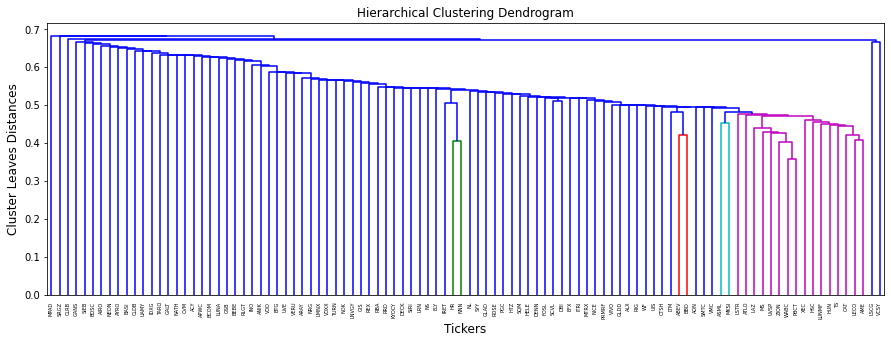

In [11]:
correlation = stock_returns_train.corr()
distances = np.sqrt((1 - correlation) / 2)
clusters = linkage(squareform(distances), method="single")


columns = stock_returns_train.columns
plt.figure(figsize=(15, 5))
dendrogram(clusters, labels=columns)
plt.xlabel('Tickers', fontsize=12)
plt.ylabel('Cluster Leaves Distances', fontsize=12)
plt.title('Hierarchical Clustering Dendrogram', fontsize=12)
plt.show()

##### Matrix Seriation
Within the matrix seriation step, the clusters found above are used to place similar assets closer together and dissimilar investments are placed further apart. “This rearranges the original covariance matrix of stocks so that larger covariances are placed along the diagonal and smaller ones around this diagonal and since the off-diagonal elements are not completely zero, this is called a quasi-diagonal covariance matrix”


<Figure size 504x504 with 0 Axes>

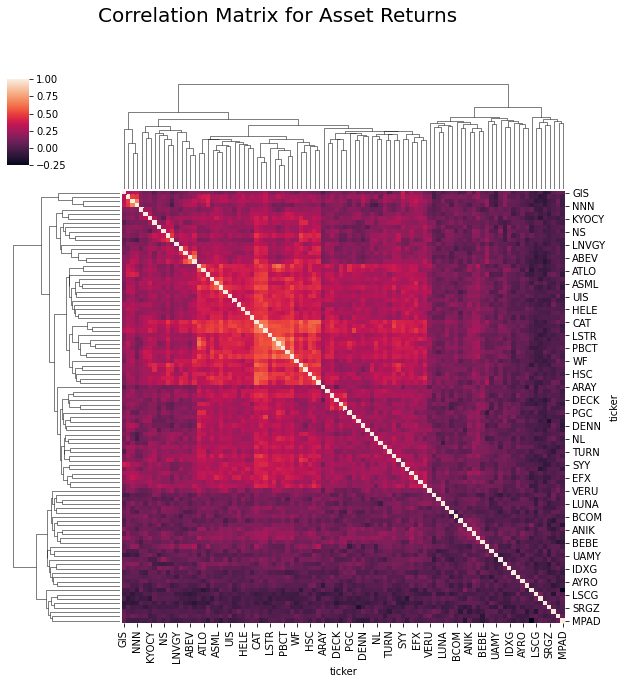

In [12]:
plt.figure(figsize=(7, 7))
g = sns.clustermap(correlation)
g.fig.suptitle('Correlation Matrix for Asset Returns', fontsize = 20)
plt.show()

##### Assign Weights
To assign weights, recursive bisection is used in the following steps:
1.	Weights are initialized to 1
<center> $W_i = 1, \quad \forall i \in {1...N} $ </center>
2.	The two large clusters found at the end of the first step are used to traverse downward giving weight to the assets
3.	The variance of each branch are calculated for each child cluster

<center>$V_{i} = \omega^T V \omega \\
\omega = \frac{diag[V]^{-1}}{trace(diag[V]^{-1})}$</center> 
4.	Assign weighting factor to each child cluster
<center> $\alpha_1 = 1 - \frac{V_1}{V_1 + V_2}; \alpha_2 = 1-\alpha_1$ </center>
5.  Set weights of subclusters
<center> $W_1 = \alpha_1 * W_1 $ </center>
<center> $W_2 = \alpha_2 * W_2 $ </center>
6.  Repeat steps 2-5 until each stock has its own weight


In [13]:
hrp = HierarchicalRiskParity()
hrp.allocate(asset_names = covariance_matrix.index,
             asset_prices=stock_prices_downsampled,
             covariance_matrix=covariance_matrix)
hrp_weights = hrp.weights.sort_values(by=0, ascending=False, axis=1)
hrp_weights

ticker,GIS,CLDB,NATH,MPAD,TARO,GANS,VOD,SYY,KYOCY,IRET,...,FOSL,HSC,AIRO,PRMRF,LUNMF,UIS,VCSY,SRGZ,LSCG,IDXG
0,0.066482,0.060102,0.035776,0.034343,0.030614,0.028074,0.027547,0.027464,0.023805,0.022734,...,0.002862,0.002409,0.002206,0.002105,0.001753,0.001542,0.000979,0.000851,0.000399,0.000201


In [24]:
hrp_weights = pd.DataFrame(columns=asset_names)
i = 0
for j in range(52,len(stock_returns)):
    hrp = HierarchicalRiskParity()
    asset_prices = stock_prices_downsampled.iloc[i:j]
    covariance_matrix = stock_returns.iloc[i:j].cov()
    hrp.allocate(asset_names = asset_names,
             asset_prices=asset_prices,
             covariance_matrix=covariance_matrix)
    hrp_weights = hrp_weights.append(hrp.weights)
    i +=1
hrp_weights.head()

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


,ABEV,ACY,AIRO,ALX,AME,ANIK,AON,APWC,ARAY,ASML,...,VCSY,VERU,VIVO,VMC,VOD,VOXX,WABC,WF,XEC,ZION
0,0.007944,0.000948,0.000526,0.003089,0.010437,0.034836,0.022312,0.020233,0.005957,0.006278,...,0.005984,0.003972,0.007227,0.003597,0.013828,0.002275,0.010528,0.004043,0.002675,0.003831
0,0.006979,0.001302,0.000564,0.004836,0.008652,0.034282,0.022680,0.019843,0.004237,0.003044,...,0.005303,0.003520,0.007089,0.004359,0.015103,0.002287,0.009413,0.002479,0.004304,0.003734
0,0.008286,0.001345,0.000533,0.003441,0.008404,0.036281,0.018445,0.018566,0.005446,0.003651,...,0.007955,0.004321,0.006192,0.004553,0.015276,0.002364,0.007670,0.004172,0.002992,0.002119
0,0.010045,0.002272,0.000702,0.002962,0.011989,0.045217,0.017390,0.026386,0.012178,0.004869,...,0.009143,0.003615,0.005968,0.005806,0.019177,0.003834,0.007662,0.004220,0.003052,0.001962
0,0.009199,0.001404,0.000523,0.006390,0.008801,0.015649,0.017448,0.022400,0.005006,0.002789,...,0.007921,0.004246,0.005761,0.005815,0.015095,0.002554,0.007957,0.002866,0.004947,0.002568


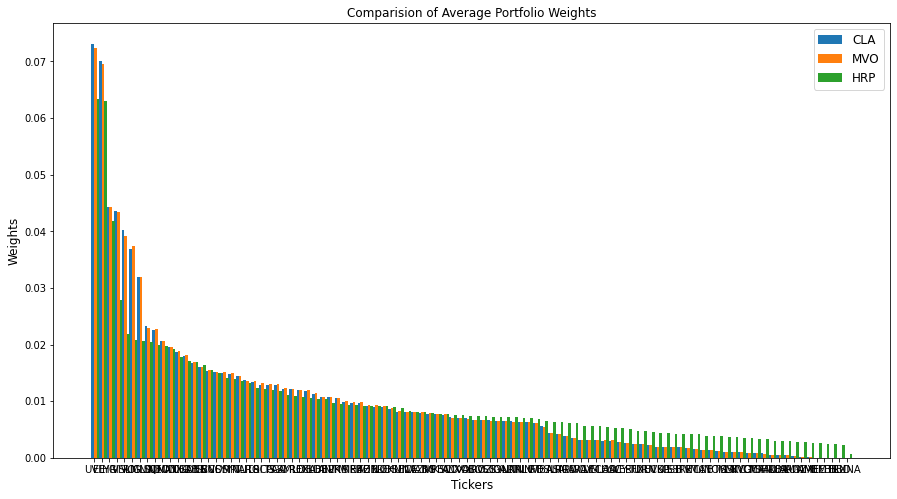

In [30]:
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111)
N = stock_prices_downsampled.shape[1]
index = np.arange(N)
width = 0.35
ax.bar(index, cla_weights[cla_weights.columns].mean().sort_values(ascending=False), width, label="CLA")
ax.bar(index + width, mvo_weights.mean().sort_values(ascending=False), width, label="MVO")
ax.bar(index + 2*width, hrp_weights.mean().sort_values(ascending=False), width, label="HRP")
ax.set_xticks(index + width / 2)
ax.set_xticklabels(cla_weights.columns)
plt.xlabel('Tickers', fontsize=12)
plt.ylabel('Weights', fontsize=12)
plt.title('Comparision of Average Portfolio Weights', fontsize=12)
plt.legend(fontsize='large')
plt.show()

#### Hierarchical Clustering Asset Allocation (HCAA)

Similar to HRP, HCAA begins with Hierarchical Tree Clustering.

However, the HCAA algorithm next calculates the optimal number of clusters rather than using single linkage to grow to the tree to maximum depth in HRP. Before allocating weights, HCAA cuts the tree to the optimal number of clusters using the Gap Index.

Gap index paper: https://statweb.stanford.edu/~gwalther/gap

The third step is the familiar recursive bisection. In this algorithm, the alphas are calculated using equal contribution to risk to calculate cluster weights. In this experiment, the Sharpe ratio is used as the risk measure.

<center> $\alpha_1 = \frac{RC_1}{RC_1 + RC_2}; \alpha_2 = 1 - \alpha_1 $</center> 

The final step is to assign asset weights within each cluster. Within the same cluster, an initial set of weights - $W_{𝐼𝑉𝑃} - is calculated using the inverse-variance allocation. The final weights are given by the following equation:

<center> $W^{i}_{final} = W^{i}_{𝐼𝑉𝑃}  * C^{i}, i \in Clusters $</center>


##### Linkage Methods
Sources:   
https://d-nb.info/1108447864/34  
https://mlfinlab.readthedocs.io/en/latest/portfolio_optimisation/hierarchical_clustering_asset_allocation.html

1. Single-Linkage

The idea behind single-linkage is to form groups of elements, which have the smallest distance to each other (nearest neighbouring clustering). This oftentimes leads to large groups/chaining.

The single-link algorithm oftentimes forms clusters that are chained together and leaves large clusters. It can probably be best understood as a way to give a “more robust” estimation of the distance matrix and furthermore preserves the original structure as much as possible. Elements departing early from the tree can be interpreted as “different” from the overall dataset. In terms of application, the single-link clustering algorithm is very useful to gain insights in the correlation structure between assets and separates assets that were very different from the rest. If this separation is preferred and high weights should be put on “outliers” the single link certainly is a good choice.

2. Complete-Linkage

The complete-linkage algorithm tries to avoid those large groups by considering the largest distances between elements. It is thus called the farthest neighbour clustering.

The complete-link algorithm has a different idea: elements should be grouped together in a way that they are not too different from each other when merged in a cluster. It thus has a much stronger definition of “similar pair of clusters”. The complete-link algorithm therefore seems suitable for investors interested in grouping stocks that are similar in one cluster.

3. Average-Linkage

The average-linkage algorithm is a compromise between the single-linkage and complete-linkage algorithm.

4. Ward-Linkage

Whereas single-linkage, complete-linkage and average-linkage can be classified as graph-based clustering algorithms, Ward’s method has a prototype-based view in which the clusters are represented by a centroid. For this reason, the proximity between clusters is usually defined as the distance between cluster centroids. The Ward method uses the increase in the sum of the squares error (SSE) to determine the clusters.

##### "Grid Search" over Linkage Methods for HCAA

In [15]:
hcaa_S = HierarchicalClusteringAssetAllocation()
hcaa_S.allocate(asset_names = covariance_matrix.index,
                asset_prices=stock_prices_downsampled,
                allocation_metric='sharpe_ratio',
                linkage='single')
hcaa_S_weights = hcaa_S.weights.sort_values(by=0, ascending=False, axis=1)

hcaa_A = HierarchicalClusteringAssetAllocation()
hcaa_A.allocate(asset_names = covariance_matrix.index,
                asset_prices=stock_prices_downsampled,
                allocation_metric='sharpe_ratio',
                linkage='average')
hcaa_A_weights = hcaa_A.weights.sort_values(by=0, ascending=False, axis=1)

hcaa_C = HierarchicalClusteringAssetAllocation()
hcaa_C.allocate(asset_names = covariance_matrix.index,
                asset_prices=stock_prices_downsampled,
                allocation_metric='sharpe_ratio',
                linkage='complete')
hcaa_C_weights = hcaa_C.weights.sort_values(by=0, ascending=False, axis=1)

hcaa_W = HierarchicalClusteringAssetAllocation()
hcaa_W.allocate(asset_names = covariance_matrix.index,
                asset_prices=stock_prices_downsampled,
                allocation_metric='sharpe_ratio',
                linkage='ward')
hcaa_W_weights = hcaa_W.weights.sort_values(by=0, ascending=False, axis=1)

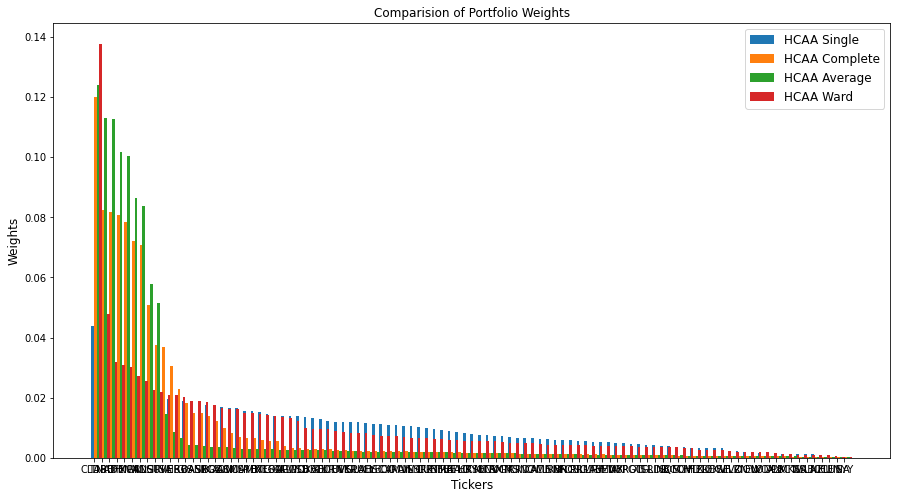

In [16]:
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111)
N = stock_prices_downsampled.shape[1]
index = np.arange(N)
width = 0.35
ax.bar(index, hcaa_S_weights.values[0], width, label="HCAA Single")
ax.bar(index + width, hcaa_C_weights.values[0], width, label="HCAA Complete")
ax.bar(index + 2*width, hcaa_A_weights.values[0], width, label="HCAA Average")
ax.bar(index + 3*width, hcaa_W_weights.values[0], width, label="HCAA Ward")
ax.set_xticks(index + width / 2)
ax.set_xticklabels(cla_weights.columns)
plt.xlabel('Tickers', fontsize=12)
plt.ylabel('Weights', fontsize=12)
plt.title('Comparision of Portfolio Weights', fontsize=12)
plt.legend(fontsize='large')
plt.show()

In [53]:
def calculate_Sharpe(returns, N=50):
    sampleMu        = returns.mean()
    sampleMuAnnual  = (sampleMu + 1)**N - 1
    sampleSig       = returns.std()
    sampleVarAnnual = (sampleSig**2 + (sampleMu+1)**2)**N - (sampleMu+1)**(2*N)
    sampleSigAnnual = np.sqrt(sampleVarAnnual)
    
    Sharpe = sampleMuAnnual/sampleSigAnnual
    return Sharpe, sampleMuAnnual, sampleSigAnnual

def calculate_drawdown(wealth):
    relativeDrawdown = []
    highWater        = wealth[0]
    for i in range(len(wealth)):
        if wealth[i] > highWater:
            highWater = wealth[i]
            relativeDrawdown.append(0)
        else:
            relativeDrawdown.append(wealth[i]/highWater -1)
    return relativeDrawdown

S Sharpe:  -0.31588617736926417
C Sharpe:  0.38924811745055155
A Sharpe:  0.3995124474136607
W Sharpe:  -0.2206838072067919


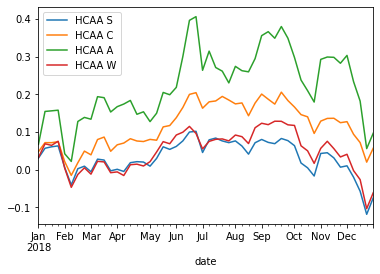

In [18]:
stock_returns_validate = stock_returns_validate.reindex(sorted(stock_returns_validate.columns), axis=1)
hcaa_S_weights = hcaa_S_weights.reindex(sorted(hcaa_S_weights.columns), axis=1)
hcaa_C_weights = hcaa_C_weights.reindex(sorted(hcaa_C_weights.columns), axis=1)
hcaa_A_weights = hcaa_A_weights.reindex(sorted(hcaa_A_weights.columns), axis=1)
hcaa_W_weights = hcaa_W_weights.reindex(sorted(hcaa_W_weights.columns), axis=1)

hcaa_S_ret = stock_returns_validate.mul(np.array(hcaa_S_weights), axis=1).sum(axis=1)
hcaa_C_ret = stock_returns_validate.mul(np.array(hcaa_C_weights), axis=1).sum(axis=1)
hcaa_A_ret = stock_returns_validate.mul(np.array(hcaa_A_weights), axis=1).sum(axis=1)
hcaa_W_ret = stock_returns_validate.mul(np.array(hcaa_W_weights), axis=1).sum(axis=1)

hcaa_cumulative_returns = pd.DataFrame()
hcaa_cumulative_returns['HCAA S'] = ((1+hcaa_S_ret).cumprod()-1)
hcaa_cumulative_returns['HCAA C'] = ((1+hcaa_C_ret).cumprod()-1)
hcaa_cumulative_returns['HCAA A'] = ((1+hcaa_A_ret).cumprod()-1)
hcaa_cumulative_returns['HCAA W'] = ((1+hcaa_W_ret).cumprod()-1)
hcaa_cumulative_returns.plot()

print("S Sharpe: " , calculate_Sharpe(hcaa_S_ret))
print("C Sharpe: " , calculate_Sharpe(hcaa_C_ret))
print("A Sharpe: " , calculate_Sharpe(hcaa_A_ret))
print("W Sharpe: ",  calculate_Sharpe(hcaa_W_ret))

##### "Grid Search" Remarks
Based on the realized Sharpe ratios over validation data, it appears the Average-Linkage method should be used in the test data.

In [31]:
hcaa_A_weights = pd.DataFrame(columns=asset_names)
i = 0
for j in range(52,len(stock_returns)):
    hcaa_A = HierarchicalClusteringAssetAllocation()
    asset_prices = stock_prices_downsampled.iloc[i:j]
    covariance_matrix = stock_returns.iloc[i:j].cov()
    hcaa_A.allocate(asset_names = asset_names,
                    asset_prices=asset_prices,
                    covariance_matrix=covariance_matrix,
                    allocation_metric='sharpe_ratio',
                    linkage='average')
    hcaa_A_weights = hcaa_A_weights.append(hcaa_A.weights)
    i +=1
hcaa_A_weights.head()

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True

,ABEV,ACY,AIRO,ALX,AME,ANIK,AON,APWC,ARAY,ASML,...,VCSY,VERU,VIVO,VMC,VOD,VOXX,WABC,WF,XEC,ZION
0,0.000266,0.002731,0.067632,0.000441,0.000659,0.000438,0.001195,0.001338,0.000898,0.001060,...,0.000622,0.001045,0.002690,0.001510,0.000016,0.000765,0.002466,0.000813,0.002076,0.021888
0,0.001016,0.001681,0.061553,0.001354,0.000802,0.000474,0.000664,0.000757,0.000494,0.001325,...,0.001516,0.090541,0.000715,0.001008,0.000371,0.000366,0.000018,0.000881,0.000619,0.000550
0,0.003634,0.002031,0.000841,0.182001,0.001071,0.007515,0.001607,0.000893,0.001706,0.002926,...,0.001444,0.000022,0.025627,0.005875,0.002187,0.000768,0.001939,0.003136,0.000377,0.000691
0,0.001486,0.002748,0.001653,0.000337,0.000454,0.063287,0.000759,0.001609,0.190275,0.000989,...,0.000437,0.000894,0.050293,0.004755,0.001320,0.001275,0.000644,0.002811,0.001738,0.001002
0,0.003942,0.001907,0.001846,0.002215,0.003869,0.001293,0.001420,0.000938,0.000971,0.032906,...,0.002316,0.003777,0.000436,0.000710,0.051522,0.000850,0.003765,0.003230,0.001430,0.000325


In [35]:
stock_returns = stock_returns.reindex(sorted(stock_returns.columns), axis=1)
mvo_weights.reindex(sorted(stock_returns.columns), axis=1)
cla_weights.reindex(sorted(stock_returns.columns), axis=1)
hrp_weights.reindex(sorted(stock_returns.columns), axis=1)
hcaa_A_weights.reindex(sorted(stock_returns.columns), axis=1)

,ABEV,ACY,AIRO,ALX,AME,ANIK,AON,APWC,ARAY,ASML,...,VCSY,VERU,VIVO,VMC,VOD,VOXX,WABC,WF,XEC,ZION
0,2.657433e-04,2.731069e-03,6.763167e-02,4.410811e-04,6.586532e-04,4.382570e-04,1.194948e-03,1.338172e-03,8.980690e-04,1.059961e-03,...,0.000622,1.045044e-03,2.690042e-03,0.001510,1.585772e-05,7.648182e-04,2.465621e-03,8.132758e-04,2.076479e-03,2.188812e-02
0,1.016021e-03,1.681055e-03,6.155338e-02,1.353601e-03,8.023510e-04,4.743183e-04,6.644750e-04,7.569415e-04,4.941857e-04,1.325335e-03,...,0.001516,9.054080e-02,7.150752e-04,0.001008,3.712380e-04,3.656340e-04,1.787832e-05,8.806362e-04,6.190824e-04,5.500922e-04
0,3.633671e-03,2.030900e-03,8.410889e-04,1.820011e-01,1.070633e-03,7.515015e-03,1.606727e-03,8.930470e-04,1.705968e-03,2.925615e-03,...,0.001444,2.174132e-05,2.562671e-02,0.005875,2.186526e-03,7.684559e-04,1.938577e-03,3.135821e-03,3.773038e-04,6.908193e-04
0,1.485698e-03,2.747851e-03,1.652907e-03,3.374013e-04,4.542301e-04,6.328699e-02,7.586671e-04,1.609203e-03,1.902746e-01,9.890492e-04,...,0.000437,8.935683e-04,5.029339e-02,0.004755,1.319915e-03,1.275449e-03,6.441640e-04,2.810775e-03,1.737703e-03,1.002070e-03
0,3.941998e-03,1.906589e-03,1.846063e-03,2.214781e-03,3.868672e-03,1.293312e-03,1.420339e-03,9.375237e-04,9.712316e-04,3.290616e-02,...,0.002316,3.777168e-03,4.355662e-04,0.000710,5.152233e-02,8.498134e-04,3.764522e-03,3.230310e-03,1.429771e-03,3.247389e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,2.770274e-06,2.969767e-06,2.497852e-06,1.915938e-06,1.073193e-04,2.792253e-06,1.271712e-06,9.929558e-01,5.283100e-06,3.299922e-06,...,0.001510,2.933751e-06,3.035844e-06,0.000004,6.699621e-07,2.277368e-06,8.496793e-05,7.187621e-07,2.470666e-06,2.007994e-06
0,5.718098e-08,5.005822e-09,2.496672e-08,1.308361e-08,5.550099e-08,2.785392e-08,8.085349e-08,7.100198e-09,8.373521e-09,3.473734e-08,...,0.000589,7.411069e-09,4.572567e-09,0.000024,2.961598e-08,1.246057e-08,7.971824e-09,7.511814e-09,1.491394e-08,3.219802e-08
0,2.993457e-05,9.381602e-06,1.859343e-05,3.021248e-05,5.487709e-05,2.235221e-04,7.156982e-05,2.528669e-05,1.279764e-05,5.479191e-05,...,0.000071,1.354465e-05,1.267098e-05,0.000022,5.722340e-05,2.741890e-04,5.517368e-05,1.096532e-04,1.512147e-05,2.998804e-05
0,7.288189e-04,8.367099e-04,1.481123e-04,1.834359e-04,9.256854e-03,9.739051e-05,2.540937e-04,4.903123e-02,1.214763e-04,7.207813e-04,...,0.000576,2.442255e-04,5.566869e-04,0.000022,1.395336e-01,3.090478e-04,4.659898e-04,6.208369e-04,2.069341e-03,7.471317e-04


In [43]:
mvo_weights = mvo_weights.set_index(stock_returns.iloc[52:].index)
cla_weights = cla_weights.set_index(stock_returns.iloc[52:].index)
hrp_weights = hrp_weights.set_index(stock_returns.iloc[52:].index)
hcaa_A_weights = hcaa_A_weights.set_index(stock_returns.iloc[52:].index)


In [45]:
mvo_ret = stock_returns.iloc[52:].mul(mvo_weights, axis=1).sum(axis=1)
cla_ret = stock_returns.iloc[52:].mul(cla_weights, axis=1).sum(axis=1)
hrp_ret = stock_returns.iloc[52:].mul(hrp_weights, axis=1).sum(axis=1)
hcaa_A_ret = stock_returns.iloc[52:].mul(hcaa_A_weights, axis=1).sum(axis=1)
equal_ret = stock_returns.iloc[52:].mul([1/100] * 100, axis=1).sum(axis=1)

Mean Weekly Std
CLA  Return: 0.002259110004990612
MVO  Return: 0.0022744710819433515
HRP  Return: 0.0010038996390198663
HCAA Average  Return: 0.002542509603088477
Equal  Return: 0.0027899029725105395


Mean Weekly Std
CLA  Std: 0.024742384145058936
MVO  Std: 0.024867512338653926
HRP  Std: 0.02061296871853315
HCAA Average  Std: 0.04013176195893547
Equal  Std: 0.028451392631566548


Annualized Return
CLA  Return: 0.11943948770846413
MVO  Return: 0.12029766173328293
HRP  Return: 0.051449620979689525
HCAA Average  Return: 0.13537630777555432
Equal  Return: 0.14946994741287223


Annualized Vol
CLA  Volatility: 0.19687781903314427
MVO  Volatility: 0.1980371482496563
HRP  Volatility: 0.15389970380487825
HCAA Average  Volatility: 0.3277829329511761
Equal  Volatility: 0.23290119514783236


Annualized Sharpe
CLA  Sharpe: 0.6066680761450154
MVO  Sharpe: 0.607449979948354
HRP  Sharpe: 0.3343061728365633
HCAA Average  Sharpe: 0.41300596878763934
Equal  Sharpe: 0.6417740678316282


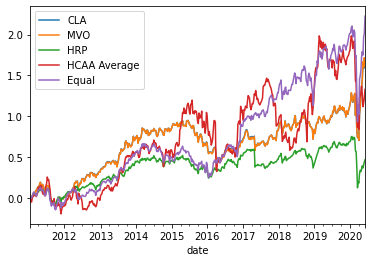

In [55]:
strategy_returns = pd.DataFrame()
cumulative_returns = pd.DataFrame()

for c, strategy in enumerate([cla_ret, mvo_ret, hrp_ret, hcaa_A_ret, equal_ret]):
    strategy_returns[c] = strategy
    cumulative_returns[c] = ((1+strategy).cumprod()-1)

cumulative_returns.columns = ["CLA", "MVO", "HRP", "HCAA Average", "Equal"]    
cumulative_returns.plot()

print("Mean Weekly Std")
for i in range(5):
    print(cumulative_returns.columns[i], " Return:", strategy_returns[i].mean())
print('\n')
print("Mean Weekly Std")
for i in range(5):
    print(cumulative_returns.columns[i], " Std:", strategy_returns[i].std())
print('\n')
print("Annualized Return")
for i in range(5):
    print(cumulative_returns.columns[i], " Return:", calculate_Sharpe(strategy_returns[i])[1])
print('\n')
print("Annualized Vol")
for i in range(5):
    print(cumulative_returns.columns[i], " Volatility:", calculate_Sharpe(strategy_returns[i])[2])
print('\n')
print("Annualized Sharpe")
for i in range(5):
    print(cumulative_returns.columns[i], " Sharpe:", calculate_Sharpe(strategy_returns[i])[0])

### Conclusion

As mentioned in the abstract, immediate issues can be seen with standard portfolio optimization methods. The size of this empirical study had to be reduced to even begin the comparison. Initially, when all stocks with full history were included, the covariance matrix was singular and the CLA and MVO optimization methods could not produce a solution. 

Using a one year look back and one week holding period, it appears that both the MVO and CLA algorithms outperform the two clustering algorithms, in terms of Sharpe ratios. The traditional techniques both produce roughly the same annualized return, 12.0% and 11.9%, respectively. The two clustering algorithms produce returns of 5.1% and 13.5%, for HRP and HCAA Average, respectively. It should also be noted that the benchmark portfolio, a naïve equal weighting scheme, had the highest annualized return, nearly 15%, and the highest Sharpe ratio, 0.64. 

From a risk management standpoint, we can have more faith in the clustering portfolios. These portfolios are inherently more diversified, which can be seen from the portfolio weight plots above. Because correlations are known to vary throughout time, holding smaller positions in more assets will increase diversification benefits. Additionally, the more assets one holds, the lower the specific risk a portfolio contains. 

However, in the above results, portfolio operations and transaction costs are not taken into account. The empirical results rely on weekly rebalancing with zero frictions and zero transaction costs. When the number of assets in the portfolio increases, frictions and frequent rebalancing of many assets will degrade returns.

Going forward several improvements can be made to this experiment. First, multiple asset classes should be tested. As stated in the abstract, classical portfolio optimization techniques perform best when correlations are close to zero. Given that each of the assets used in this experiment were in the US equity market, they have inherently high correlations. Further experimentation should be done using several index funds such as US and International Equity Indices, Bond/ High-Yield Indices, etc. to test the robustness of the clustering algorithms. Additionally, because each of these algorithms rely on a covariance matrix, utilizing denoising techniques to the covariance matrix could potentially improve results for all models and make the optimization techniques generalize better to out of sample data. 
